### Atribución en el espacio latente (SHAP)

Sea $x$ el conectoma multicanal y $f:\mathbb{R}^d\to[0,1]$ el clasificador que recibe $\mu(x)\in\mathbb{R}^d$ (medias latentes del VAE) y metadatos $m$.
Para cada latente $\ell$, el valor SHAP $ \phi_\ell(x) $ aproxima la contribución marginal esperada de $\mu_\ell(x)$ a $f$.
Definimos un peso discriminativo por latente como diferencia de medias entre grupos:

$$
w_\ell \;=\; \mathbb{E}[\phi_\ell \mid AD]\;-\;\mathbb{E}[\phi_\ell \mid CN],
\qquad \text{y normalizamos } \; \tilde{w}_\ell = \frac{w_\ell}{\sum_k |w_k|}.
$$

Estos $\tilde{w}$ inducen una función escalar de saliencia
$$
F(x)\;=\;\sum_{\ell=1}^d \tilde{w}_\ell\, \mu_\ell(x) \;=\; \tilde{w}^{\top}\,\mu(x),
$$
que resume “hacia AD” (signo +) o “hacia CN” (−) en el espacio latente.


In [1]:
!python interpretar_fold_gemini_pro.py saliency \
    --run_dir ./resultados67 --fold 1 --clf gb \
    --global_tensor_path /home/diego/Escritorio/limpio/AAL3_dynamicROIs_fmri_tensor_NeuroEnhanced_v6.5.17_AAL3_131ROIs_OMST_GCE_Signed_GrangerLag1_ChNorm_ROIreorderedYeo17_ParallelTuned/GLOBAL_TENSOR_from_AAL3_dynamicROIs_fmri_tensor_NeuroEnhanced_v6.5.17_AAL3_131ROIs_OMST_GCE_Signed_GrangerLag1_ChNorm_ROIreorderedYeo17_ParallelTuned.npz \
    --metadata_path /home/diego/Escritorio/limpio/SubjectsData_AAL3_procesado2.csv \
    --roi_annotation_path /home/diego/Escritorio/limpio/roi_info_master.csv \
    --channels_to_use 1 2 4 5 \
    --channel_names 'Pearson_Full_FisherZ_Signed' 'MI_KNN_Symmetric' 'dFC_StdDev' 'DistanceCorr' \
    --latent_dim 48 \
    --latent_features_type mu \
    --metadata_features Age Sex Manufacturer \
    --num_conv_layers_encoder 4 \
    --decoder_type convtranspose \
    --dropout_rate_vae 0.25 \
    --use_layernorm_vae_fc \
    --intermediate_fc_dim_vae half \
    --vae_final_activation linear \
    --gn_num_groups 16 \
    --saliency_method integrated_gradients \
    --ig_n_steps 100

[INFO] [SALIENCY] fold=1 clf=gb  (pack cargado: shap_pack_gb.joblib)
[INFO] Usando ROI order de resultados67/roi_order_131.joblib.
[INFO] Cargado fichero de anotaciones: /home/diego/Escritorio/limpio/roi_info_master.csv
[INFO] [SALIENCY] 48 latentes ponderadas. Ejemplo:
 latent_idx    weight  importance           feature
         28  0.184933    0.000214 latent__latent_28
          8 -0.135120   -0.000157  latent__latent_8
         46  0.113080    0.000131 latent__latent_46
          5  0.063333    0.000073  latent__latent_5
         33  0.062660    0.000073 latent__latent_33
[INFO] [SALIENCY] Sujetos AD=19  CN=18
[INFO] [SALIENCY] Usando método de saliencia: integrated_gradients
[INFO] [SALIENCY] Ranking de conexiones ANOTADO guardado: resultados67/fold_1/interpretability_gb/ranking_conexiones_ANOTADO_integrated_gradients_top50.csv
[INFO] Top 20 conexiones anotadas:
      Rank src_AAL3_Name dst_AAL3_Name  Saliency_Score          src_Refined_Network        dst_Refined_Network
3624     

# Análisis de Interpretabilidad de Biomarcadores de Conectividad para Alzheimer

Este notebook realiza un análisis exhaustivo de los resultados de interpretabilidad generados por el pipeline `interpretar_fold_gemini_pro.py`. El objetivo es descomponer la "caja negra" del modelo de clasificación para identificar y validar los biomarcadores de conectividad funcional que diferencian a pacientes con Enfermedad de Alzheimer (AD) de Controles Sanos (CN).

## Metodología de Interpretabilidad: Un Viaje de Ida y Vuelta

Nuestro enfoque sigue una secuencia lógica de tres etapas para pasar del espacio de datos de alta dimensionalidad (conectomas) a una decisión de clasificación, y luego de vuelta al espacio de datos para la interpretación neurobiológica.

### Etapa 1: Codificación No-Lineal a un Espacio Latente (VAE)
El punto de partida es un conjunto de conectomas funcionales, $X \in \mathbb{R}^{C \times R \times R}$, donde $C$ es el número de canales (métricas de conectividad) y $R$ es el número de Regiones de Interés (ROIs). La alta dimensionalidad de este espacio es un desafío para la clasificación directa.

Utilizamos un **Autoencoder Variacional Convolucional (VAE)**, un modelo generativo no supervisado, para aprender una representación comprimida y significativa de cada conectoma. El **encoder** del VAE, $E_\phi(X)$, mapea cada conectoma $X$ a una distribución en un espacio latente de baja dimensionalidad, parametrizada por una media $\mu \in \mathbb{R}^{D_L}$ y una varianza $\log(\sigma^2) \in \mathbb{R}^{D_L}$, donde $D_L \ll C \times R \times R$.

$$ E_\phi(X) \rightarrow (\mu, \log \sigma^2) $$

Para la clasificación, utilizamos el vector de medias $\mu$ como un "resumen" o *embedding* neurofuncional del conectoma. Este vector captura las características más salientes y variadas de la conectividad del sujeto en $D_L$ dimensiones.

### Etapa 2: Clasificación y Atribución de Importancia en el Espacio Latente (Clasificador + SHAP)
El vector latente $\mu$, junto con metadatos demográficos (edad, sexo), se utiliza como entrada para un clasificador robusto (en este caso, un Gradient Boosting, $g_\theta$).

$$ \hat{y} = g_\theta([\mu, \text{metadatos}]) $$

Una vez que el clasificador $g_\theta$ está entrenado, empleamos **SHAP (SHapley Additive exPlanations)** para cuantificar la importancia de cada una de las $D_L$ dimensiones latentes en la decisión del modelo. SHAP asigna a cada característica latente $\mu_k$ un valor $\phi_k$ que representa su contribución marginal a la predicción para un sujeto dado.

### Etapa 3: Retroproyección al Espacio de Conexiones (Integrated Gradients)
Aquí reside el núcleo de la interpretabilidad. Queremos saber: ¿qué conexiones específicas en el conectoma original $X$ son responsables de la formación de las características latentes que SHAP nos dijo que eran importantes?

Para ello, construimos una **función de saliencia escalar** $f(X)$ que representa la "energía discriminativa" de un conectoma. Esta se define como el producto punto entre el vector de medias latentes $\mu(X)$ y un vector de pesos $\mathbf{w}$:

$$ f(X) = \mathbf{w}^\top \mu(X) $$

El vector de pesos $\mathbf{w}$ se deriva directamente de los valores SHAP, específicamente, de la diferencia del valor SHAP promedio para cada dimensión latente entre los grupos AD y CN: $\mathbf{w} = \mathbb{E}[\phi_{AD}] - \mathbb{E}[\phi_{CN}]$.

Con esta función, utilizamos **Integrated Gradients (IG)** para atribuir la saliencia de $f(X)$ a cada conexión individual $X_{ij}$ en el conectoma de entrada. IG calcula la integral de los gradientes de $f(X)$ a lo largo de una trayectoria rectilínea desde una *baseline* (línea de base) informativa $\tilde{X}$ (en nuestro caso, un conectoma nulo) hasta el conectoma de entrada $X$.

$$ \text{IG}_{ij}(X) = (X_{ij} - \tilde{X}_{ij}) \int_{\alpha=0}^{1} \frac{\partial f(\tilde{X} + \alpha(X - \tilde{X}))}{\partial X_{ij}} d\alpha $$

La métrica final que analizamos es la **saliencia diferencial**, $\Delta S_{ij}$, calculada como la diferencia en la magnitud de IG promedio entre los grupos:

$$ \Delta S_{ij} = \mathbb{E}_{x \sim AD}[|\text{IG}_{ij}(X)|] - \mathbb{E}_{x \sim CN}[|\text{IG}_{ij}(X)|] $$

Un $\Delta S_{ij} > 0$ indica una conexión más importante para la clasificación de AD, mientras que $\Delta S_{ij} < 0$ indica mayor importancia para la clasificación de CN.


### Integrated Gradients hacia el espacio de conexiones

Queremos atribuir $F(x)=\tilde{w}^{\top}\mu(x)$ a cada entrada $x_{c,ij}$ (canal $c$, conexión $i\text{–}j$).
Con baseline $\bar{x}$ (aquí, un conectoma nulo) y trayectoria recta $x(\alpha)=\bar{x}+\alpha(x-\bar{x})$,
las **Integrated Gradients** son

$$
\mathrm{IG}_{c,ij}(x) \;=\; (x_{c,ij}-\bar{x}_{c,ij}) \,\int_{0}^{1}\! 
\frac{\partial F(x(\alpha))}{\partial x_{c,ij}} \, d\alpha .
$$

Promediamos $|\mathrm{IG}|$ por sujetos de cada grupo para obtener $S_{c,ij}^{AD}$ y $S_{c,ij}^{CN}$.
La **saliencia diferencial** que reportamos por conexión es
$$
\Delta S_{ij} \;=\; \sum_{c} \Big( \mathbb{E}_{AD}|\mathrm{IG}_{c,ij}| \;-\; \mathbb{E}_{CN}|\mathrm{IG}_{c,ij}| \Big).
$$
Rojo ($+$) indica mayor saliencia para AD; azul ($-$) para CN.



In [2]:
#config y carga de datos
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from pathlib import Path
from scipy.stats import spearmanr, binomtest, hypergeom, linregress
from statsmodels.stats.multitest import multipletests

# --- Configuración de Estilo ---
sns.set_theme(style="whitegrid", context="paper", font_scale=1.2)

# --- Definir Rutas ---
BASE_DIR = Path('/home/diego/Escritorio/limpio/')
RUN_DIR = BASE_DIR / 'resultados67'
FOLD = 1
CLF = 'gb'
INTERP_DIR = RUN_DIR / f'fold_{FOLD}' / f'interpretability_{CLF}'
SUFFIX = '_integrated_gradients_top50'

# --- Cargar Archivos de Análisis ---
try:
    with open(INTERP_DIR / f'run_args_saliency{SUFFIX}.json', 'r') as f:
        run_args = json.load(f)
    
    df_edges = pd.read_csv(INTERP_DIR / f'ranking_conexiones_ANOTADO{SUFFIX}.csv')
    df_channels = pd.read_csv(INTERP_DIR / f'channel_contributions{SUFFIX}.csv')
    df_net_pairs_abs = pd.read_csv(INTERP_DIR / f'network_pairs_sumabs{SUFFIX}.csv', index_col=0)
    df_hubs_robust200 = pd.read_csv(INTERP_DIR / f'node_robust_hubs_top200{SUFFIX}.csv')
    
    print(f"Análisis del Fold {run_args.get('fold')} para '{run_args.get('clf')}' cargado exitosamente.")
except FileNotFoundError as e:
    print(f"Error: No se encontró un archivo de análisis. {e}")
    print(">>> ASEGÚRATE DE HABER RE-EJECUTADO EL SCRIPT PARCHADO. <<<")

Análisis del Fold 1 para 'gb' cargado exitosamente.


## Parte 1: La Firma de Saliencia del Alzheimer

Comenzamos nuestro análisis desde la perspectiva más amplia, identificando los sistemas y nodos cerebrales clave, para luego descender al nivel de las conexiones individuales.

### 1.1. Epicentros de la Discriminación: Análisis de Redes y Hubs

Primero, identificamos los **hubs de saliencia**: ROIs que son los puntos de origen o destino de las conexiones más discriminativas. Para asegurar que estos hubs no son un artefacto de su alta conectividad, calculamos una **fuerza de saliencia robusta** (residuales de una regresión sobre el grado del nodo).

A continuación, agregamos la saliencia a nivel de **pares de redes funcionales**. Esto nos permite visualizar qué sistemas cerebrales muestran una interacción anómala en AD.

### Agregación por pares de redes y enriquecimiento

Construimos matrices $M^{(\text{abs})}$ y $M^{(\text{sgn})}$ donde
$$
M^{(\text{abs})}_{A,B}=\sum_{(i\in A,\,j\in B)} |\Delta S_{ij}|, \qquad
M^{(\text{sgn})}_{A,B}=\sum_{(i\in A,\,j\in B)} \Delta S_{ij}.
$$
Para **enriquecimiento** en Top-K, comparamos el conteo observado $k$ de un par $(A,B)$ frente a su disponibilidad
en la población de aristas $E$ usando hipergeométrica ($p=\Pr[X\ge k]$), y controlamos FDR por Benjamini–Hochberg.


/tmp/ipykernel_29689/2890302960.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_hubs_plot, x='residual_strength', y='node', palette='plasma_r')


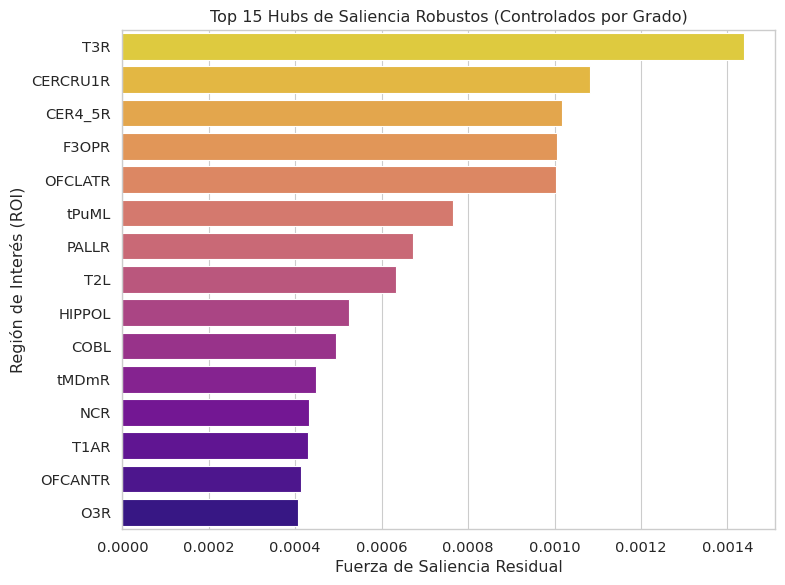

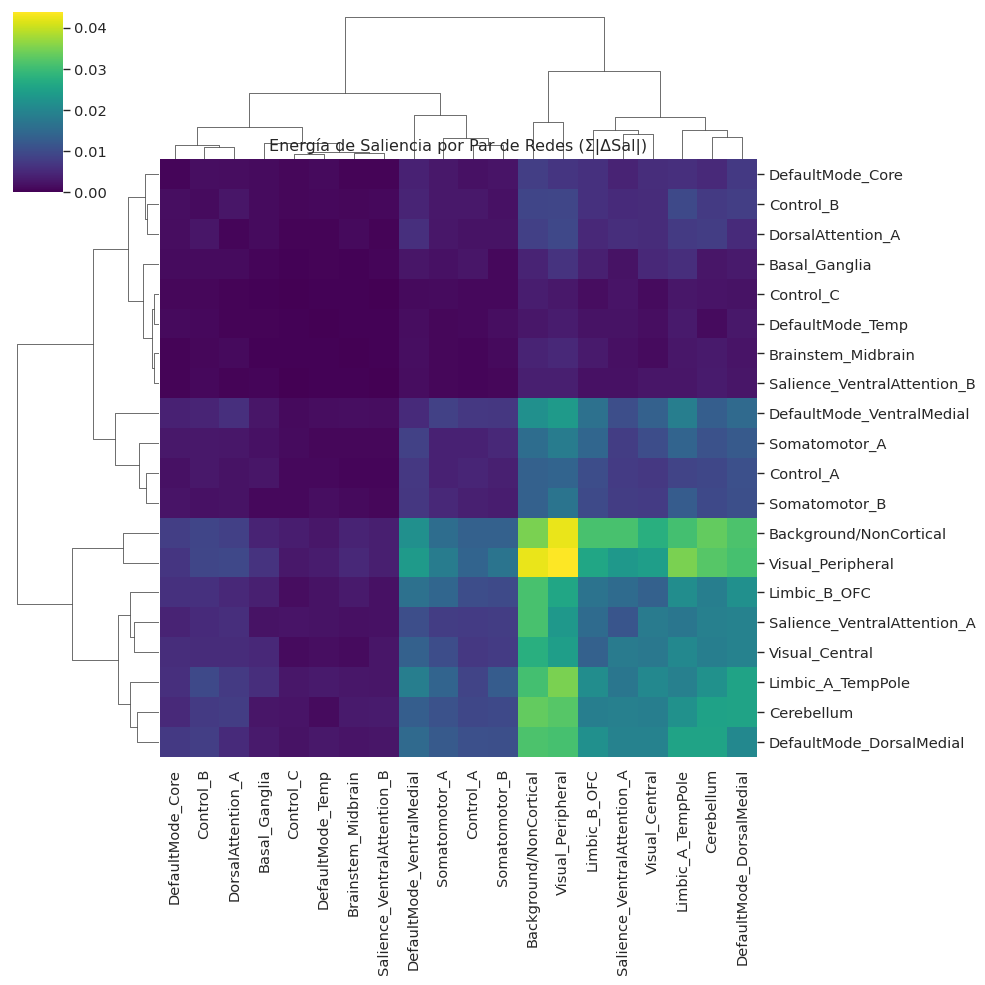

In [3]:
if 'df_hubs_robust200' in locals() and 'df_net_pairs_abs' in locals():
    # --- Hubs Robustos ---
    df_hubs_plot = df_hubs_robust200.sort_values('residual_strength', ascending=False).head(15)
    plt.figure(figsize=(8, 6))
    sns.barplot(data=df_hubs_plot, x='residual_strength', y='node', palette='plasma_r')
    plt.title('Top 15 Hubs de Saliencia Robustos (Controlados por Grado)')
    plt.xlabel('Fuerza de Saliencia Residual')
    plt.ylabel('Región de Interés (ROI)')
    plt.tight_layout()
    plt.show()

    # --- Clustermap de Redes ---
    cg = sns.clustermap(df_net_pairs_abs, method='average', metric='euclidean', cmap='viridis', figsize=(10,10))
    cg.ax_heatmap.set_title('Energía de Saliencia por Par de Redes (Σ|ΔSal|)')
    plt.setp(cg.ax_heatmap.get_xticklabels(), rotation=90)
    plt.setp(cg.ax_heatmap.get_yticklabels(), rotation=0)
    plt.show()

### 1.2. Las Conexiones Más Relevantes

Descendemos al nivel más granular, examinando las conexiones individuales con mayor saliencia diferencial. Presentamos las 10 conexiones más importantes para la clasificación de AD ($\Delta S > 0$) y las 10 más importantes para la de CN ($\Delta S < 0$).

In [4]:
if 'df_edges' in locals():
    display_cols = ['Rank', 'src_AAL3_Name', 'dst_AAL3_Name', 'Saliency_Score', 'src_Refined_Network', 'dst_Refined_Network']
    
    print("--- Top 10 Conexiones más Salientes para AD (ΔS > 0) ---")
    display(df_edges[df_edges['Saliency_Score'] > 0].head(10)[display_cols])
    
    print("\n--- Top 10 Conexiones más Salientes para CN (ΔS < 0) ---")
    display(df_edges[df_edges['Saliency_Score'] < 0].head(10)[display_cols])

--- Top 10 Conexiones más Salientes para AD (ΔS > 0) ---


,Rank,src_AAL3_Name,dst_AAL3_Name,Saliency_Score,src_Refined_Network,dst_Refined_Network
0,1,OFCLATR,CERCRU1R,0.002129,DefaultMode_VentralMedial,Visual_Peripheral
1,2,OFCLATR,T3R,0.002114,DefaultMode_VentralMedial,Limbic_A_TempPole
6,7,OFCLATR,T2R,0.001375,DefaultMode_VentralMedial,DorsalAttention_A
9,10,OFCLATR,T2AL,0.001284,DefaultMode_VentralMedial,Limbic_A_TempPole
13,14,OFCLATR,CER10R,0.001202,DefaultMode_VentralMedial,Cerebellum
16,17,HESCHLR,VER7,0.001178,Somatomotor_B,Background/NonCortical
18,19,OFCLATR,GAR,0.001161,DefaultMode_VentralMedial,DefaultMode_DorsalMedial
20,21,CINML,VER7,0.001124,Salience_VentralAttention_A,Background/NonCortical
21,22,NLL,CERCRU1R,0.001115,Background/NonCortical,Visual_Peripheral
22,23,OFCANTR,OFCLATR,0.001109,Control_B,DefaultMode_VentralMedial



--- Top 10 Conexiones más Salientes para CN (ΔS < 0) ---


,Rank,src_AAL3_Name,dst_AAL3_Name,Saliency_Score,src_Refined_Network,dst_Refined_Network
2,3,F3OPR,GRR,-0.001692,Control_A,Limbic_B_OFC
3,4,CER4_5R,tPuML,-0.001603,Visual_Central,Background/NonCortical
4,5,GSMR,VER4_5,-0.001560,Salience_VentralAttention_A,Visual_Central
5,6,O3R,T1AR,-0.001383,Visual_Peripheral,Limbic_A_TempPole
7,8,PARA_HIPPOR,PALLR,-0.001370,Limbic_A_TempPole,Basal_Ganglia
8,9,GRL,T2L,-0.001331,Limbic_B_OFC,DefaultMode_VentralMedial
10,11,SMAR,FMOR,-0.001254,Somatomotor_A,DefaultMode_DorsalMedial
11,12,HIPPOL,PQL,-0.001222,DefaultMode_Core,DefaultMode_DorsalMedial
12,13,CER4_5R,tMDmR,-0.001208,Visual_Central,Background/NonCortical
14,15,SMAR,COBL,-0.001191,Somatomotor_A,Limbic_B_OFC


## Parte 2: Validación y Profundización Estadística

Habiendo identificado la firma de saliencia, ahora la sometemos a un escrutinio estadístico riguroso para validar su robustez y comprender su naturaleza.

### 2.1. ¿Son Significativos los Patrones de Red? Test de Enriquecimiento

Realizamos un **test de enriquecimiento hipergeométrico** para determinar si los pares de redes con alta saliencia están sobrerrepresentados en las conexiones más importantes (Top-K) de lo que se esperaría por azar. Corregimos los p-valores con el método de Benjamini-Hochberg (FDR) para controlar la tasa de falsos descubrimientos.

In [5]:
import pandas as pd, numpy as np, scipy.stats as st, pathlib

RUN_DIR = pathlib.Path('/home/diego/Escritorio/limpio/resultados67/fold_1/interpretability_gb')
edges = pd.read_csv(RUN_DIR / 'ranking_conexiones_ANOTADO_integrated_gradients_top50.csv')

net_src = 'src_Refined_Network' if 'src_Refined_Network' in edges.columns else 'src_Yeo17_Network'
net_dst = 'dst_Refined_Network' if 'dst_Refined_Network' in edges.columns else 'dst_Yeo17_Network'

def pair_label(a,b): 
    return '—'.join(sorted([str(a),str(b)]))

edges['pair'] = [pair_label(a,b) for a,b in zip(edges[net_src], edges[net_dst])]

def enrich_K(K):
    top = edges.nsmallest(K, 'Rank')
    E = len(edges)  # población = todas las aristas
    pop_counts = edges['pair'].value_counts()
    k_obs = top['pair'].value_counts()
    out = []
    for p, k in k_obs.items():
        M = pop_counts.get(p,0)  # éxitos en población
        N = K                    # tamaño de muestra
        # P(X >= k) hipergeométrica
        pval = st.hypergeom.sf(k-1, E, M, N)
        out.append((p, k, M, E, N, pval))
    df = pd.DataFrame(out, columns=['pair','k_top','M_pop','E_total','N_top','pval']).sort_values('pval')
    # BH
    m = len(df); ranks = np.arange(1, m+1)
    df['qval_BH'] = (df['pval'] * m / ranks).clip(upper=1).cummin()
    return df

for K in (50,100,200):
    dfk = enrich_K(K)
    dfk.to_csv(RUN_DIR / f'enrichment_network_pairs_top{K}.csv', index=False)
    display(dfk.head(10))


,pair,k_top,M_pop,E_total,N_top,pval,qval_BH
5,DefaultMode_VentralMedial—DorsalAttention_A,2,18,8515,50,0.004869,0.185025
0,DefaultMode_VentralMedial—Visual_Peripheral,3,78,8515,50,0.010643,0.185025
6,DefaultMode_VentralMedial—Limbic_A_TempPole,2,60,8515,50,0.048197,0.185025
18,Brainstem_Midbrain—Cerebellum,1,11,8515,50,0.062764,0.185025
2,Background/NonCortical—Somatomotor_B,2,70,8515,50,0.063390,0.185025
29,DefaultMode_Temp—Visual_Peripheral,1,13,8515,50,0.073754,0.185025
22,Brainstem_Midbrain—Visual_Peripheral,1,13,8515,50,0.073754,0.185025
20,Background/NonCortical—Brainstem_Midbrain,1,14,8515,50,0.079201,0.185025
7,Background/NonCortical—DefaultMode_VentralMedial,2,84,8515,50,0.086941,0.185025
1,Background/NonCortical—Visual_Peripheral,3,182,8515,50,0.090823,0.185025


,pair,k_top,M_pop,E_total,N_top,pval,qval_BH
1,DefaultMode_VentralMedial—Limbic_A_TempPole,5,60,8515,100,0.000662,0.038377
0,Background/NonCortical—Salience_VentralAttenti...,6,112,8515,100,0.001980,0.038377
2,DefaultMode_VentralMedial—Visual_Peripheral,5,78,8515,100,0.002166,0.038377
22,DefaultMode_VentralMedial—DorsalAttention_A,2,18,8515,100,0.018486,0.038377
6,DefaultMode_VentralMedial—Limbic_B_OFC,3,72,8515,100,0.052393,0.038377
3,Limbic_A_TempPole—Visual_Peripheral,4,130,8515,100,0.066453,0.038377
41,Brainstem_Midbrain—DefaultMode_VentralMedial,1,6,8515,100,0.068447,0.038377
7,Background/NonCortical—DefaultMode_VentralMedial,3,84,8515,100,0.075823,0.038377
17,DefaultMode_VentralMedial—Salience_VentralAtte...,2,48,8515,100,0.108859,0.038377
37,Control_C—Limbic_A_TempPole,1,10,8515,100,0.111480,0.038377


,pair,k_top,M_pop,E_total,N_top,pval,qval_BH
0,DefaultMode_VentralMedial—Visual_Peripheral,8,78,8515,200,0.000462,0.042012
4,DefaultMode_VentralMedial—Limbic_A_TempPole,6,60,8515,200,0.002716,0.042012
3,Background/NonCortical—DefaultMode_VentralMedial,7,84,8515,200,0.003491,0.042012
2,Background/NonCortical—Salience_VentralAttenti...,8,112,8515,200,0.004757,0.042012
11,DefaultMode_VentralMedial—Visual_Central,5,54,8515,200,0.008463,0.042012
1,Limbic_A_TempPole—Visual_Peripheral,8,130,8515,200,0.011381,0.042012
8,Visual_Peripheral—Visual_Peripheral,5,78,8515,200,0.036109,0.042012
10,Somatomotor_A—Visual_Peripheral,5,91,8515,200,0.062605,0.042012
42,DefaultMode_VentralMedial—DorsalAttention_A,2,18,8515,200,0.065650,0.042012
21,DefaultMode_VentralMedial—Somatomotor_A,3,42,8515,200,0.075168,0.042012


### 2.2. Saliencia del Modelo vs. Efecto de Grupo en la Conectividad

Una pregunta crítica es si la saliencia del modelo simplemente refleja grandes diferencias en la conectividad media entre grupos o si captura patrones más sutiles. Para ello, calculamos el **d de Cohen** para cada conexión (una medida del tamaño del efecto de la diferencia de medias) y lo correlacionamos (Spearman ρ) con la magnitud de la saliencia. Un `jointplot` nos permite visualizar esta relación y las distribuciones de ambas métricas.

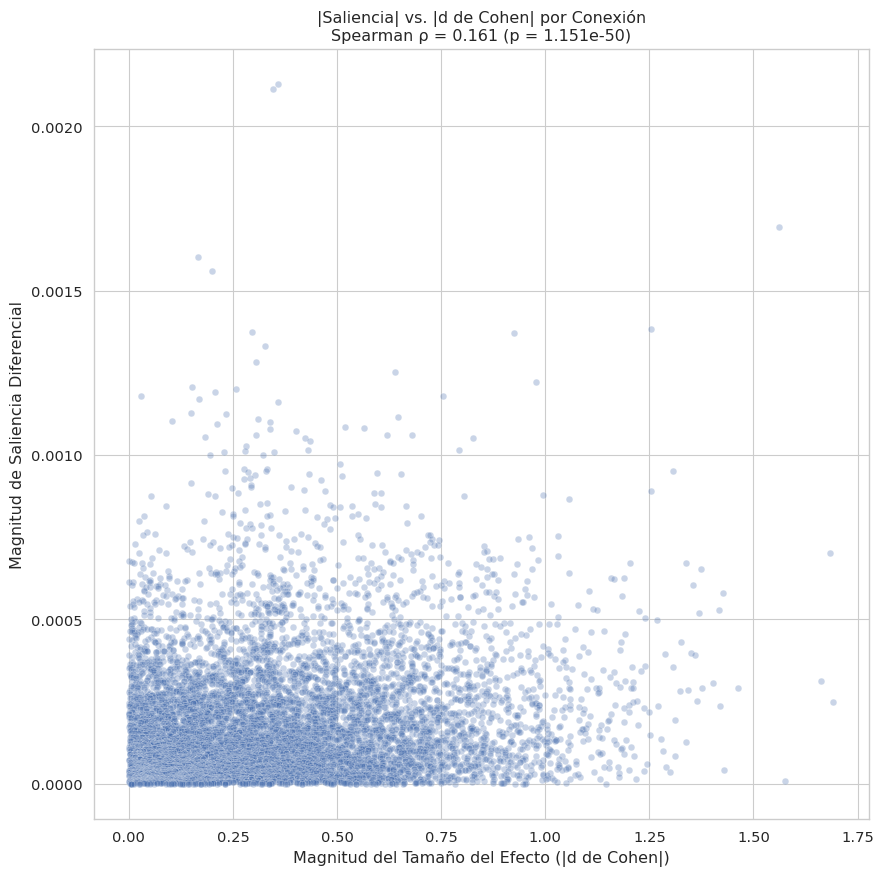

In [6]:
# --- ¡ATENCIÓN! ---
# El siguiente código requiere acceso a los datos originales del tensor de conectividad
# y a los metadatos para separar a los sujetos. Debes asegurarte de que las
# rutas a los archivos .npz, .csv y .npy sean correctas.

# --- Rutas (MODIFICAR SEGÚN SEA NECESARIO) ---
GLOBAL_TENSOR_PATH = '/home/diego/Escritorio/limpio/AAL3_dynamicROIs_fmri_tensor_NeuroEnhanced_v6.5.17_AAL3_131ROIs_OMST_GCE_Signed_GrangerLag1_ChNorm_ROIreorderedYeo17_ParallelTuned/GLOBAL_TENSOR_from_AAL3_dynamicROIs_fmri_tensor_NeuroEnhanced_v6.5.17_AAL3_131ROIs_OMST_GCE_Signed_GrangerLag1_ChNorm_ROIreorderedYeo17_ParallelTuned.npz'
METADATA_PATH = '/home/diego/Escritorio/limpio/SubjectsData_AAL3_procesado2.csv'
RUN_DIR = './resultados67'
FOLD = 1
CHANNELS_TO_USE = [1, 2, 4, 5] # Canales usados en el entrenamiento

# --- Función para calcular d de Cohen ---
def cohen_d(x, y):
    nx, ny = len(x), len(y)
    dof = nx + ny - 2
    pooled_std = np.sqrt(((nx - 1) * np.std(x, ddof=1) ** 2 + (ny - 1) * np.std(y, ddof=1) ** 2) / dof)
    if pooled_std == 0:
        return 0
    return (np.mean(x) - np.mean(y)) / pooled_std

# --- Cargar datos necesarios ---
try:
    # 1. Cargar tensores y metadatos
    npz_data = np.load(GLOBAL_TENSOR_PATH)
    tensor_all = npz_data['global_tensor_data']
    subj_all_ids = npz_data['subject_ids'].astype(str)
    
    meta_df = pd.read_csv(METADATA_PATH)
    meta_df['SubjectID'] = meta_df['SubjectID'].astype(str).str.strip()

    # 2. Identificar sujetos de test para este fold
    fold_dir = f"{RUN_DIR}/fold_{FOLD}"
    test_indices_in_cnad_df = np.load(f"{fold_dir}/test_indices.npy")
    
    # Recrear el dataframe de sujetos CN/AD para obtener los IDs
    tensor_df = pd.DataFrame({'SubjectID': subj_all_ids, 'tensor_idx': np.arange(len(subj_all_ids))})
    merged = tensor_df.merge(meta_df, on='SubjectID', how='left')
    cnad_df = merged[merged['ResearchGroup_Mapped'].isin(['CN', 'AD'])].reset_index(drop=True)
    
    test_df = cnad_df.iloc[test_indices_in_cnad_df]
    
    # 3. Separar tensores de test para AD y CN
    gidx_test_ad = test_df[test_df['ResearchGroup_Mapped'] == 'AD']['tensor_idx'].values
    gidx_test_cn = test_df[test_df['ResearchGroup_Mapped'] == 'CN']['tensor_idx'].values

    # Promediar sobre los canales, ya que la saliencia también se promedió
    tensor_test_ad = tensor_all[gidx_test_ad][:, CHANNELS_TO_USE, :, :].mean(axis=1)
    tensor_test_cn = tensor_all[gidx_test_cn][:, CHANNELS_TO_USE, :, :].mean(axis=1)
    
    # 4. Calcular d de Cohen para cada conexión
    cohen_ds = []
    for _, row in df_edges.iterrows():
        i, j = int(row['idx_i']), int(row['idx_j'])
        conn_ad = tensor_test_ad[:, i, j]
        conn_cn = tensor_test_cn[:, i, j]
        d = cohen_d(conn_ad, conn_cn)
        cohen_ds.append(d)
        
    df_edges['cohen_d'] = cohen_ds
    df_edges['abs_cohen_d'] = np.abs(cohen_ds)
    df_edges['abs_saliency'] = df_edges['Saliency_Score'].abs()

    # 5. Correlación y visualización
    corr, p_value = spearmanr(df_edges['abs_saliency'], df_edges['abs_cohen_d'])

    plt.figure(figsize=(10, 10))
    sns.scatterplot(data=df_edges, x='abs_cohen_d', y='abs_saliency', alpha=0.3)
    plt.title(f'|Saliencia| vs. |d de Cohen| por Conexión\nSpearman ρ = {corr:.3f} (p = {p_value:.3e})')
    plt.xlabel('Magnitud del Tamaño del Efecto (|d de Cohen|)')
    plt.ylabel('Magnitud de Saliencia Diferencial')
    plt.show()

except FileNotFoundError as e:
    print(f"No se pudieron cargar los archivos de datos necesarios: {e}")
    print("Omitiendo cálculo de d de Cohen.")

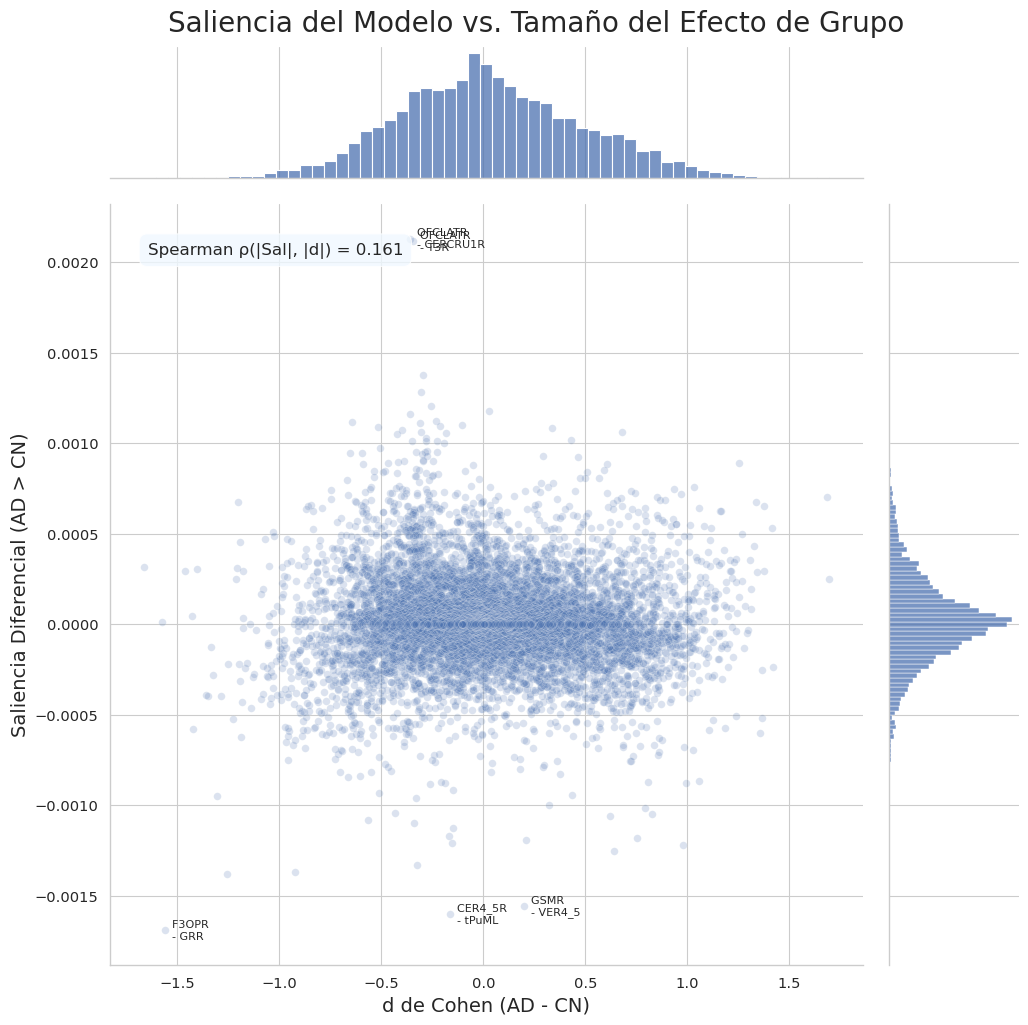

In [7]:
# --- ¡ATENCIÓN! ---
# Esta celda depende de la Celda 5 de la respuesta anterior para cargar los datos 
# del tensor y calcular el d de Cohen. Asegúrate de que esas variables estén disponibles.
# Aquí nos centramos en la visualización mejorada.

if 'df_edges' in locals() and 'cohen_d' in df_edges.columns:
    # Crear el jointplot
    g = sns.jointplot(
        data=df_edges, 
        x='cohen_d', 
        y='Saliency_Score', 
        kind="scatter",
        height=10,
        alpha=0.2,
        s=30, # Tamaño de los puntos
        edgecolor='w'
    )
    g.set_axis_labels("d de Cohen (AD - CN)", "Saliencia Diferencial (AD > CN)", fontsize=14)
    g.fig.suptitle('Saliencia del Modelo vs. Tamaño del Efecto de Grupo', y=1.02, fontsize=20)

    # Añadir la correlación de Spearman de las magnitudes
    corr, p_value = spearmanr(df_edges['Saliency_Score'].abs(), df_edges['cohen_d'].abs())
    g.ax_joint.text(
        0.05, 0.95, 
        f'Spearman ρ(|Sal|, |d|) = {corr:.3f}', 
        transform=g.ax_joint.transAxes, 
        ha='left', va='top', fontsize=12,
        bbox=dict(boxstyle='round,pad=0.5', fc='aliceblue', alpha=0.8)
    )

    # Anotar los puntos más extremos para dar contexto
    top_points = df_edges.sort_values('abs_saliency', ascending=False).head(5)
    for i, point in top_points.iterrows():
        g.ax_joint.text(
            point['cohen_d'], point['Saliency_Score'], 
            f"  {point['src_AAL3_Name']}\n  - {point['dst_AAL3_Name']}", 
            fontsize=8,
            verticalalignment='center'
        )
        
    plt.show()

else:
    print("La columna 'cohen_d' no fue calculada. Ejecuta el código de cálculo primero.")

### 2.3. ¿De Dónde Viene la Información? Contribución por Canal y Lateralidad

Finalmente, investigamos dos fuentes de variación:
- **Contribución por Canal**: Analizamos qué métrica de conectividad (canal) aporta la mayor "energía" de saliencia, revelando qué tipo de dinámica funcional es más discriminativa.
- **Asimetría Hemisférica**: Usamos un **test binomial** para determinar si existe una lateralización estadísticamente significativa en las conexiones más salientes (p. ej., si las conexiones dentro del hemisferio derecho son más frecuentes de lo esperado).

Fold 1 – clf=gb – canales=[1, 2, 4, 5]


,channel_index_used,channel_name,l1_norm,l1_norm_fraction
0,1,Pearson_Full_FisherZ_Signed,5.033197,0.286748
1,2,MI_KNN_Symmetric,4.388445,0.250015
2,4,dFC_StdDev,5.121708,0.291790
3,5,DistanceCorr,3.009366,0.171447


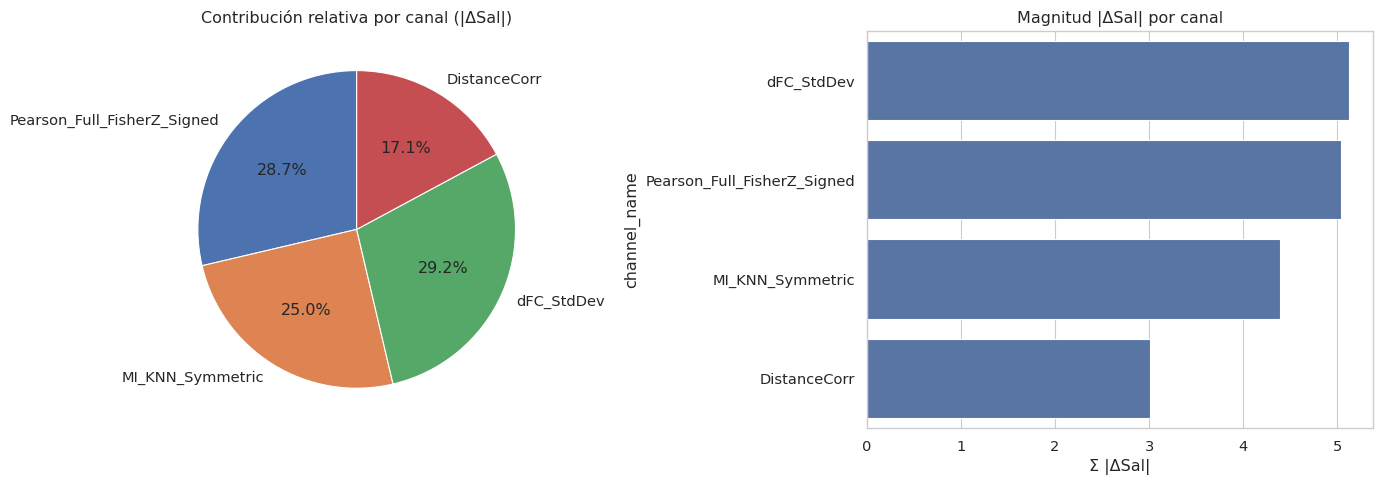

In [8]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns, json, pathlib
sns.set_theme(style="whitegrid", context="paper", font_scale=1.2)

RUN_DIR = pathlib.Path('/home/diego/Escritorio/limpio/resultados67/fold_1/interpretability_gb')
ARGS = json.load(open(RUN_DIR / 'run_args_saliency_integrated_gradients_top50.json'))
print(f"Fold {ARGS['fold']} – clf={ARGS['clf']} – canales={ARGS['channels_to_use']}")

dfc = pd.read_csv(RUN_DIR / 'channel_contributions.csv')
display(dfc)

fig, ax = plt.subplots(1,2, figsize=(14,5))
# Pie (fracciones)
ax[0].pie(dfc['l1_norm_fraction'], labels=dfc['channel_name'], autopct='%1.1f%%', startangle=90)
ax[0].set_title('Contribución relativa por canal (|ΔSal|)')
# Barras (magnitud)
sns.barplot(data=dfc.sort_values('l1_norm', ascending=False), x='l1_norm', y='channel_name', ax=ax[1])
ax[1].set_title('Magnitud |ΔSal| por canal'); ax[1].set_xlabel('Σ |ΔSal|')
plt.tight_layout(); plt.show()


### Lateralidad y hubs robustos

**Lateralidad:** clasificamos aristas Top-K en R–R, L–L, R–L, L–R y usamos un **test binomial** para R–R vs L–L (H0: p=0.5).  
**Hubs robustos:** para Top-K calculamos, por nodo, el **node-strength** $s$ (suma de $|\Delta S|$) y el **grado** $d$. 
Ajustamos $s$ por $d$ con una regresión lineal $s\approx \beta_0+\beta_1 d$; los **residuales** identifican hubs
con fuerza “excesiva” no explicada por su grado.


In [9]:
import re, pandas as pd, numpy as np, scipy.stats as st, pathlib
RUN_DIR = pathlib.Path('/home/diego/Escritorio/limpio/resultados67/fold_1/interpretability_gb')
edges = pd.read_csv(RUN_DIR / 'ranking_conexiones_ANOTADO_integrated_gradients_top50.csv')

def hemi(name):
    s = str(name)
    if s.endswith('L'): return 'L'
    if s.endswith('R'): return 'R'
    # fallback por si hay nombres sin sufijo
    m = re.search(r'_(L|R)$', s)
    return m.group(1) if m else 'U'

edges['hemi_src'] = edges['src_AAL3_Name'].map(hemi)
edges['hemi_dst'] = edges['dst_AAL3_Name'].map(hemi)

from scipy.stats import binomtest

def lat_counts(K):
    top = edges.nsmallest(K, 'Rank').copy()
    cats = {'R-R':0,'L-L':0,'R-L':0,'L-R':0,'U':0}
    for _,r in top.iterrows():
        a,b = r['hemi_src'], r['hemi_dst']
        if a in 'LR' and b in 'LR':
            if a==b=='R': cats['R-R']+=1
            elif a==b=='L': cats['L-L']+=1
            elif a!=b and a=='R': cats['R-L']+=1
            elif a!=b and a=='L': cats['L-R']+=1
        else:
            cats['U']+=1
    n_rr = cats['R-R']; n_ll = cats['L-L']
    denom = max(n_rr+n_ll, 1)
    pval = binomtest(n_rr, denom, 0.5, alternative='greater').pvalue
    return pd.Series({**cats, 'n_total_sided': denom + cats['R-L'] + cats['L-R'], 'p_binom_R> L': pval})


for K in (50,100,200):
    print(f'Top-{K}')
    display(lat_counts(K))


Top-50


R-R              29.000000
L-L               6.000000
R-L               6.000000
L-R               4.000000
U                 5.000000
n_total_sided    45.000000
p_binom_R> L      0.000058
dtype: float64

Top-100


R-R              5.100000e+01
L-L              9.000000e+00
R-L              1.400000e+01
L-R              1.300000e+01
U                1.300000e+01
n_total_sided    8.700000e+01
p_binom_R> L     1.542518e-08
dtype: float64

Top-200


R-R              8.100000e+01
L-L              2.300000e+01
R-L              4.200000e+01
L-R              2.600000e+01
U                2.800000e+01
n_total_sided    1.720000e+02
p_binom_R> L     4.672351e-09
dtype: float64

## SHAP del clasificador y vector discriminativo en el espacio latente

Sea $f: \mathbb{R}^{p} \to [0,1]$ la probabilidad para la clase positiva (AD) tras el *preprocessor*. Los valores SHAP $\phi_{n,j}$ satisfacen (aprox.) la descomposición aditiva
$$
f(z_n) \approx \mathbb{E}[f(Z)] \;+\; \sum_{j=1}^{p} \phi_{n,j}.
$$
Restringimos nuestra atención a las **features latentes** $j \in \mathcal{L}\subset\{1,\dots,p\}$, identificadas por el patrón `latent_*` tras el *preprocessor*.

Para obtener un **peso discriminativo latente** estable usamos el contraste AD vs. CN a nivel de SHAP:
$$
\Delta_{\text{SHAP},j} \;=\; \mathbb{E}_{n:\,y_n=1}\,[\phi_{n,j}] \;-\; \mathbb{E}_{n:\,y_n=0}\,[\phi_{n,j}], \quad j\in\mathcal{L}.
$$
Normalizamos por $\ell_1$ para inducir un funcional lineal bien condicionado:
$$
w_j \;=\; \frac{\Delta_{\text{SHAP},j}}{\sum_{k\in\mathcal{L}} \lvert \Delta_{\text{SHAP},k}\rvert}\,,\qquad w\in\mathbb{R}^{d}.
$$
Este $w$ pondera dimensiones latentes de acuerdo con su **diferencia explicativa** entre grupos.


## Saliencia en el espacio de conectividad vía Integrated Gradients

Definimos el funcional objetivo sobre la entrada $X$:
$$
F(X) \;=\; w^\top \mu_\theta(X),
$$
donde $\mu_\theta(X)$ es la salida del encoder (vector medio latente). La **atribución IG** de una entrada escalar $X_{c,ij}$ (canal $c$, arista $i\!-\!j$) con *baseline* $X'$ es
$$
\mathrm{IG}_{c,ij}(X;X') \;=\; (X_{c,ij}-X'_{c,ij}) \int_0^1 
\frac{\partial F\!\left(X' + \alpha (X - X')\right)}{\partial X_{c,ij}}\, d\alpha.
$$
Usamos *baseline* nula $X'=0$ (matriz hueca), coherente con la normalización *off-diag* y con la semántica “sin conectividad efectiva” como referencia.

Para un grupo $g\in\{\text{AD},\text{CN}\}$ agregamos **magnitudes** de IG por sujeto y promediamos:
$$
S^{(g)}_{c,ij} \;=\; \mathbb{E}_{n\in g}\left[\,\bigl|\mathrm{IG}_{c,ij}(X_n;0)\bigr|\,\right].
$$
La **saliencia diferencial** es
$$
\Delta S_{c,ij} \;=\; S^{(\text{AD})}_{c,ij} \;-\; S^{(\text{CN})}_{c,ij}.
$$
Signo $>0$ indica mayor relevancia para AD; $<0$ mayor relevancia para CN. Para priorización global, ordenamos aristas por $|\overline{\Delta S}_{ij}|$, donde $\overline{\Delta S}_{ij}=\frac{1}{C}\sum_c \Delta S_{c,ij}$.


## Descomposición por canal

La **contribución por canal** se define como la norma $\ell_1$ acumulada de $\Delta S$:
$$
\mathrm{L1}_c \;=\; \sum_{i<j} \left| \Delta S_{c,ij} \right|,
\qquad
\text{Fracción}_c \;=\; \frac{\mathrm{L1}_c}{\sum_{c'} \mathrm{L1}_{c'}}.
$$
Esto evalúa qué modalidad de conectividad concentra mayor “energía explicativa” diferencial entre grupos.


## Agregación por pares de redes

Agrupamos aristas por par de redes $g,h$ (según anotación de ROIs). Definimos:
$$
M^{\text{abs}}_{g,h} \;=\; \sum_{(i,j)\in (g,h)} \left| \overline{\Delta S}_{ij} \right|,
\qquad
M^{\text{sgn}}_{g,h} \;=\; \sum_{(i,j)\in (g,h)} \overline{\Delta S}_{ij}.
$$
La matriz $M^{\text{abs}}$ refleja “energía” diferencial (independiente del signo). La matriz $M^{\text{sgn}}$ retiene dirección (AD vs. CN). Para visualizar patrones se aplica *clustering* jerárquico sobre $M^{\text{abs}}$ y escala simétrica en $M^{\text{sgn}}$.

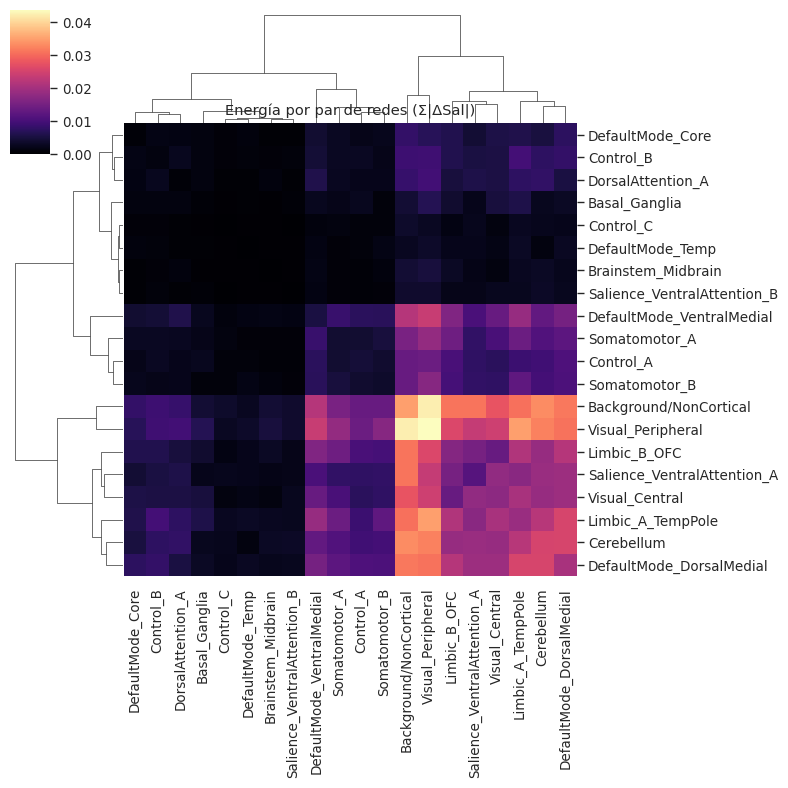

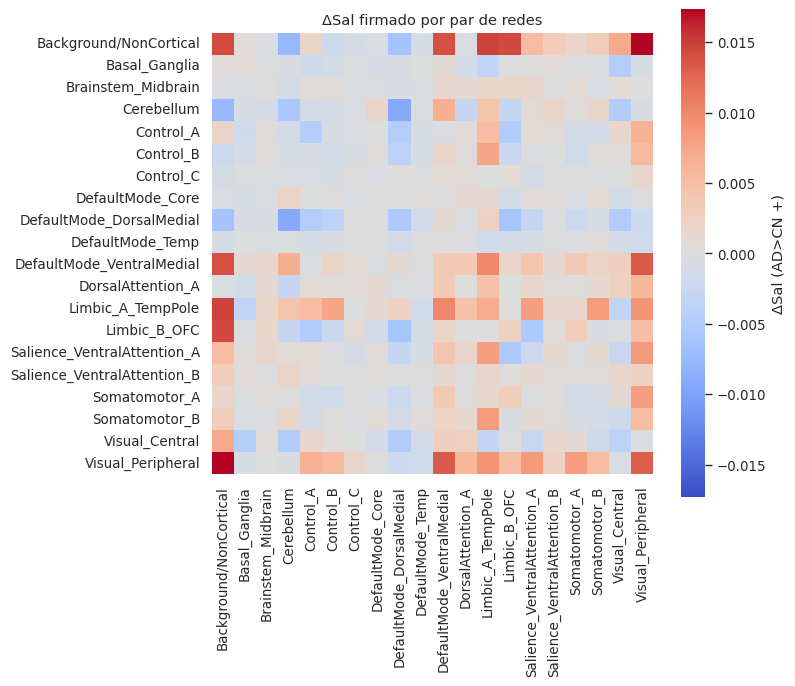

In [10]:
import pandas as pd, seaborn as sns, matplotlib.pyplot as plt, numpy as np, pathlib
sns.set_theme(style="white", context="paper", font_scale=1.1)
RUN_DIR = pathlib.Path('/home/diego/Escritorio/limpio/resultados67/fold_1/interpretability_gb')

Mabs = pd.read_csv(RUN_DIR / 'network_pairs_sumabs_integrated_gradients_top50.csv', index_col=0)
Msig = pd.read_csv(RUN_DIR / 'network_pairs_signed_integrated_gradients_top50.csv', index_col=0)

# Clustering sobre la energía (sum|ΔSal|)
cg = sns.clustermap(Mabs, method='average', metric='euclidean', cmap='magma', figsize=(8,8))
cg.ax_heatmap.set_title('Energía por par de redes (Σ|ΔSal|)')
plt.show()

# Signed con escala simétrica
v = np.nanmax(np.abs(Msig.values))
plt.figure(figsize=(8,7))
sns.heatmap(Msig, cmap='coolwarm', vmin=-v, vmax=v, center=0, square=True, cbar_kws={'label':'ΔSal (AD>CN +)'})
plt.title('ΔSal firmado por par de redes')
plt.tight_layout(); plt.show()


## Enriquecimiento Top-K de pares de redes

Al seleccionar las $K$ aristas con mayor $|\overline{\Delta S}_{ij}|$, contamos ocurrencias por par de redes $p$.
Con:
- población $E$: número total de aristas,
- éxitos en población $M_p$: aristas del par $p$ en todo el grafo,
- tamaño de muestra $N=K$,
- éxitos observados $k_p$ en el Top-K,

evaluamos $P(X \ge k_p)$ para $X\sim \mathrm{Hypergeom}(E, M_p, N)$. Corregimos *p-values* con **Benjamini–Hochberg (BH)** para controlar FDR. Pares con $q<0.05$ se consideran enriquecidos.


## Lateralidad de aristas de alto impacto

Clasificamos Top-K en categorías {R–R, L–L, R–L/L–R} ignorando nodos sin hemisferio. Para asimetría ipsilateral derecha vs. izquierda,
contrastamos $n_{RR}$ vs. $n_{LL}$ con un **test binomial unilateral** (H0: $p=0.5$). Reportamos $p$-valor y conteos.


In [11]:
import re, pandas as pd, numpy as np, scipy.stats as st, pathlib
RUN_DIR = pathlib.Path('/home/diego/Escritorio/limpio/resultados67/fold_1/interpretability_gb')
edges = pd.read_csv(RUN_DIR / 'ranking_conexiones_ANOTADO_integrated_gradients_top50.csv')

def hemi(name):
    s = str(name)
    if s.endswith('L'): return 'L'
    if s.endswith('R'): return 'R'
    # fallback por si hay nombres sin sufijo
    m = re.search(r'_(L|R)$', s)
    return m.group(1) if m else 'U'

edges['hemi_src'] = edges['src_AAL3_Name'].map(hemi)
edges['hemi_dst'] = edges['dst_AAL3_Name'].map(hemi)

from scipy.stats import binomtest

def lat_counts(K):
    top = edges.nsmallest(K, 'Rank').copy()
    cats = {'R-R':0,'L-L':0,'R-L':0,'L-R':0,'U':0}
    for _,r in top.iterrows():
        a,b = r['hemi_src'], r['hemi_dst']
        if a in 'LR' and b in 'LR':
            if a==b=='R': cats['R-R']+=1
            elif a==b=='L': cats['L-L']+=1
            elif a!=b and a=='R': cats['R-L']+=1
            elif a!=b and a=='L': cats['L-R']+=1
        else:
            cats['U']+=1
    n_rr = cats['R-R']; n_ll = cats['L-L']
    denom = max(n_rr+n_ll, 1)
    pval = binomtest(n_rr, denom, 0.5, alternative='greater').pvalue
    return pd.Series({**cats, 'n_total_sided': denom + cats['R-L'] + cats['L-R'], 'p_binom_R> L': pval})


for K in (50,100,200):
    print(f'Top-{K}')
    display(lat_counts(K))


Top-50


R-R              29.000000
L-L               6.000000
R-L               6.000000
L-R               4.000000
U                 5.000000
n_total_sided    45.000000
p_binom_R> L      0.000058
dtype: float64

Top-100


R-R              5.100000e+01
L-L              9.000000e+00
R-L              1.400000e+01
L-R              1.300000e+01
U                1.300000e+01
n_total_sided    8.700000e+01
p_binom_R> L     1.542518e-08
dtype: float64

Top-200


R-R              8.100000e+01
L-L              2.300000e+01
R-L              4.200000e+01
L-R              2.600000e+01
U                2.800000e+01
n_total_sided    1.720000e+02
p_binom_R> L     4.672351e-09
dtype: float64

## Hubs robustos: fuerza de nodo ajustada por grado

En Top-K, definimos la **fuerza** del nodo $i$:
$$
s_i \;=\; \sum_{j:\,(i,j)\in \text{Top-}K} \left| \overline{\Delta S}_{ij} \right|,
$$
y su **grado** $d_i$ como el número de aristas incidentes en Top-K. Para separar “popularidad” (grado) de “peso” (fuerza), ajustamos la relación $s_i \approx \beta_0 + \beta_1 d_i$ por OLS y reportamos el **residuo**:
$$
r_i \;=\; s_i - (\hat{\beta}_0 + \hat{\beta}_1 d_i).
$$
Nodos con $r_i$ alto concentran impacto diferencial más allá de lo esperado por su grado.

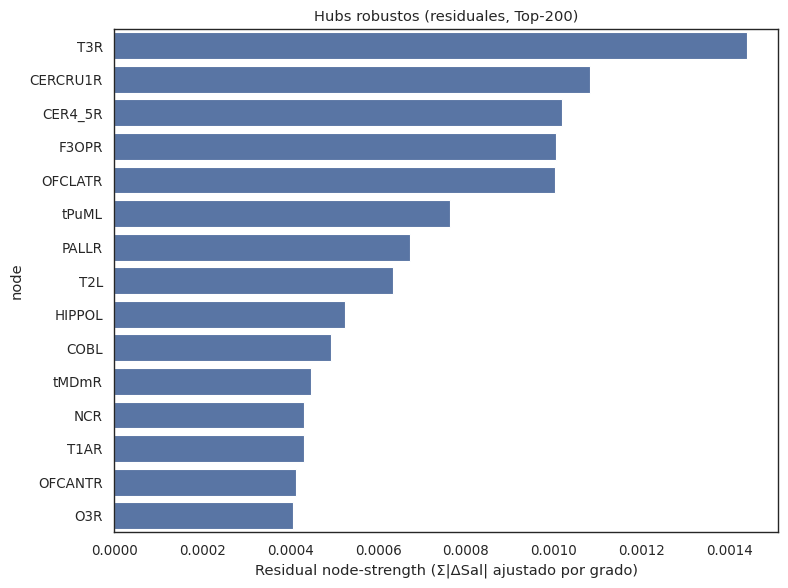

In [12]:
import pandas as pd, seaborn as sns, matplotlib.pyplot as plt, pathlib
RUN_DIR = pathlib.Path('/home/diego/Escritorio/limpio/resultados67/fold_1/interpretability_gb')

hubs200 = pd.read_csv(RUN_DIR / 'node_robust_hubs_top200_integrated_gradients_top50.csv')
top = hubs200.sort_values('residual_strength', ascending=False).head(15)
plt.figure(figsize=(8,6))
sns.barplot(data=top, x='residual_strength', y='node')
plt.title('Hubs robustos (residuales, Top-200)')
plt.xlabel('Residual node-strength (Σ|ΔSal| ajustado por grado)')
plt.tight_layout(); plt.show()


# Análisis Profundo de Saliencia Diferencial (Fold 1)

Este notebook expande el análisis de interpretabilidad de los resultados del `fold 1` para el clasificador `gb`. Nuestro objetivo es validar la robustez de los hallazgos y profundizar en su significado neurobiológico, siguiendo un plan de análisis riguroso.

## Fundamento Metodológico: Integrated Gradients (IG)

La métrica central de este análisis es la **saliencia diferencial**. Esta se deriva de las atribuciones de características calculadas con *Integrated Gradients*. La función sobre la cual calculamos las atribuciones es la proyección de la salida del encoder del VAE, $\mu(x)$, sobre un vector de pesos discriminativos, $\mathbf{w}$:

$$ f(x) = \mathbf{w}^\top \mu(x) $$

Donde $\mathbf{w}$ se construye a partir de la diferencia de los valores SHAP promedio entre los grupos AD y CN para las características del espacio latente. La atribución de IG para una característica de entrada $x_i$ (es decir, una conexión cerebral) se define como:

$$ \mathrm{IG}_i(x) = (x_i - \tilde{x}_i) \int_{\alpha=0}^{1} \frac{\partial f(\tilde{x} + \alpha(x - \tilde{x}))}{\partial x_i} d\alpha $$

En nuestro caso, usamos una *baseline* (línea de base) nula, $\tilde{x} = \mathbf{0}$. El mapa de saliencia para un grupo se calcula como la media de las magnitudes de estas atribuciones, $| \mathrm{IG}_i(x) |$, para todos los sujetos de ese grupo. Finalmente, el mapa diferencial que analizamos es:

$$ \text{SalienciaDiferencial} = \mathbb{E}_{x \sim \text{AD}}[|\text{IG}(x)|] - \mathbb{E}_{x \sim \text{CN}}[|\text{IG}(x)|] $$

Un valor **positivo (rojo)** indica que una conexión es más saliente para identificar el grupo AD, mientras que un valor **negativo (azul)** indica mayor saliencia para el grupo CN.

Ahora, procedemos a cargar los datos y comenzar el análisis.

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr

# --- Configuración de Estilo para Plots ---
sns.set_theme(style="whitegrid", context="talk")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['axes.labelsize'] = 14

# --- Cargar el Ranking de Conexiones ---
# Este es nuestro fichero principal de resultados para el Fold 1
try:
    df_edges = pd.read_csv('/home/diego/Escritorio/limpio/resultados67/fold_1/interpretability_gb/ranking_conexiones_ANOTADO_integrated_gradients_top50.csv')
    print("Fichero de ranking de conexiones cargado exitosamente.")
    print(f"Total de conexiones analizadas: {len(df_edges)}")
except FileNotFoundError:
    print("Error: Asegúrate de que el archivo 'ranking_conexiones_ANOTADO_integrated_gradients_top50.csv' esté en el mismo directorio.")
    df_edges = pd.DataFrame() # Crear un DF vacío para que no fallen las celdas siguientes

# --- Mostrar un resumen de los datos ---
if not df_edges.empty:
    print("\nPrimeras 5 conexiones más salientes (por magnitud):")
    display(df_edges.head())

Fichero de ranking de conexiones cargado exitosamente.
Total de conexiones analizadas: 8515

Primeras 5 conexiones más salientes (por magnitud):


,Rank,idx_i,idx_j,Saliency_Score,ROI_i_name,ROI_j_name,src_AAL3_Name,dst_AAL3_Name,src_Macro_Lobe,dst_Macro_Lobe,src_Refined_Network,dst_Refined_Network,src_Yeo17_Network,dst_Yeo17_Network
0,1,31,91,0.002129,OFCLATR,CERCRU1R,OFCLATR,CERCRU1R,Other,Cerebellum,DefaultMode_VentralMedial,Visual_Peripheral,DefaultMode_VentralMedial,Visual_Peripheral
1,2,31,89,0.002114,OFCLATR,T3R,OFCLATR,T3R,Other,Temporal,DefaultMode_VentralMedial,Limbic_A_TempPole,DefaultMode_VentralMedial,Limbic_A_TempPole
2,3,7,23,-0.001692,F3OPR,GRR,F3OPR,GRR,Frontal,Other,Control_A,Limbic_B_OFC,Control_A,Limbic_B_OFC
3,4,97,121,-0.001603,CER4_5R,tPuML,CER4_5R,tPuML,Cerebellum,Subcortical,Visual_Central,Background/NonCortical,Visual_Central,Background/NonCortical
4,5,65,109,-0.001560,GSMR,VER4_5,GSMR,VER4_5,Parietal,Cerebellum,Salience_VentralAttention_A,Visual_Central,Salience_VentralAttention_A,Visual_Central


/tmp/ipykernel_29689/1659533862.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=node_saliency_strength.head(top_n_nodes).values, y=node_saliency_strength.head(top_n_nodes).index, ax=axes[0], palette="viridis")
/tmp/ipykernel_29689/1659533862.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=network_pair_strength.head(top_n_pairs).values, y=pair_labels, ax=axes[1], palette="plasma")


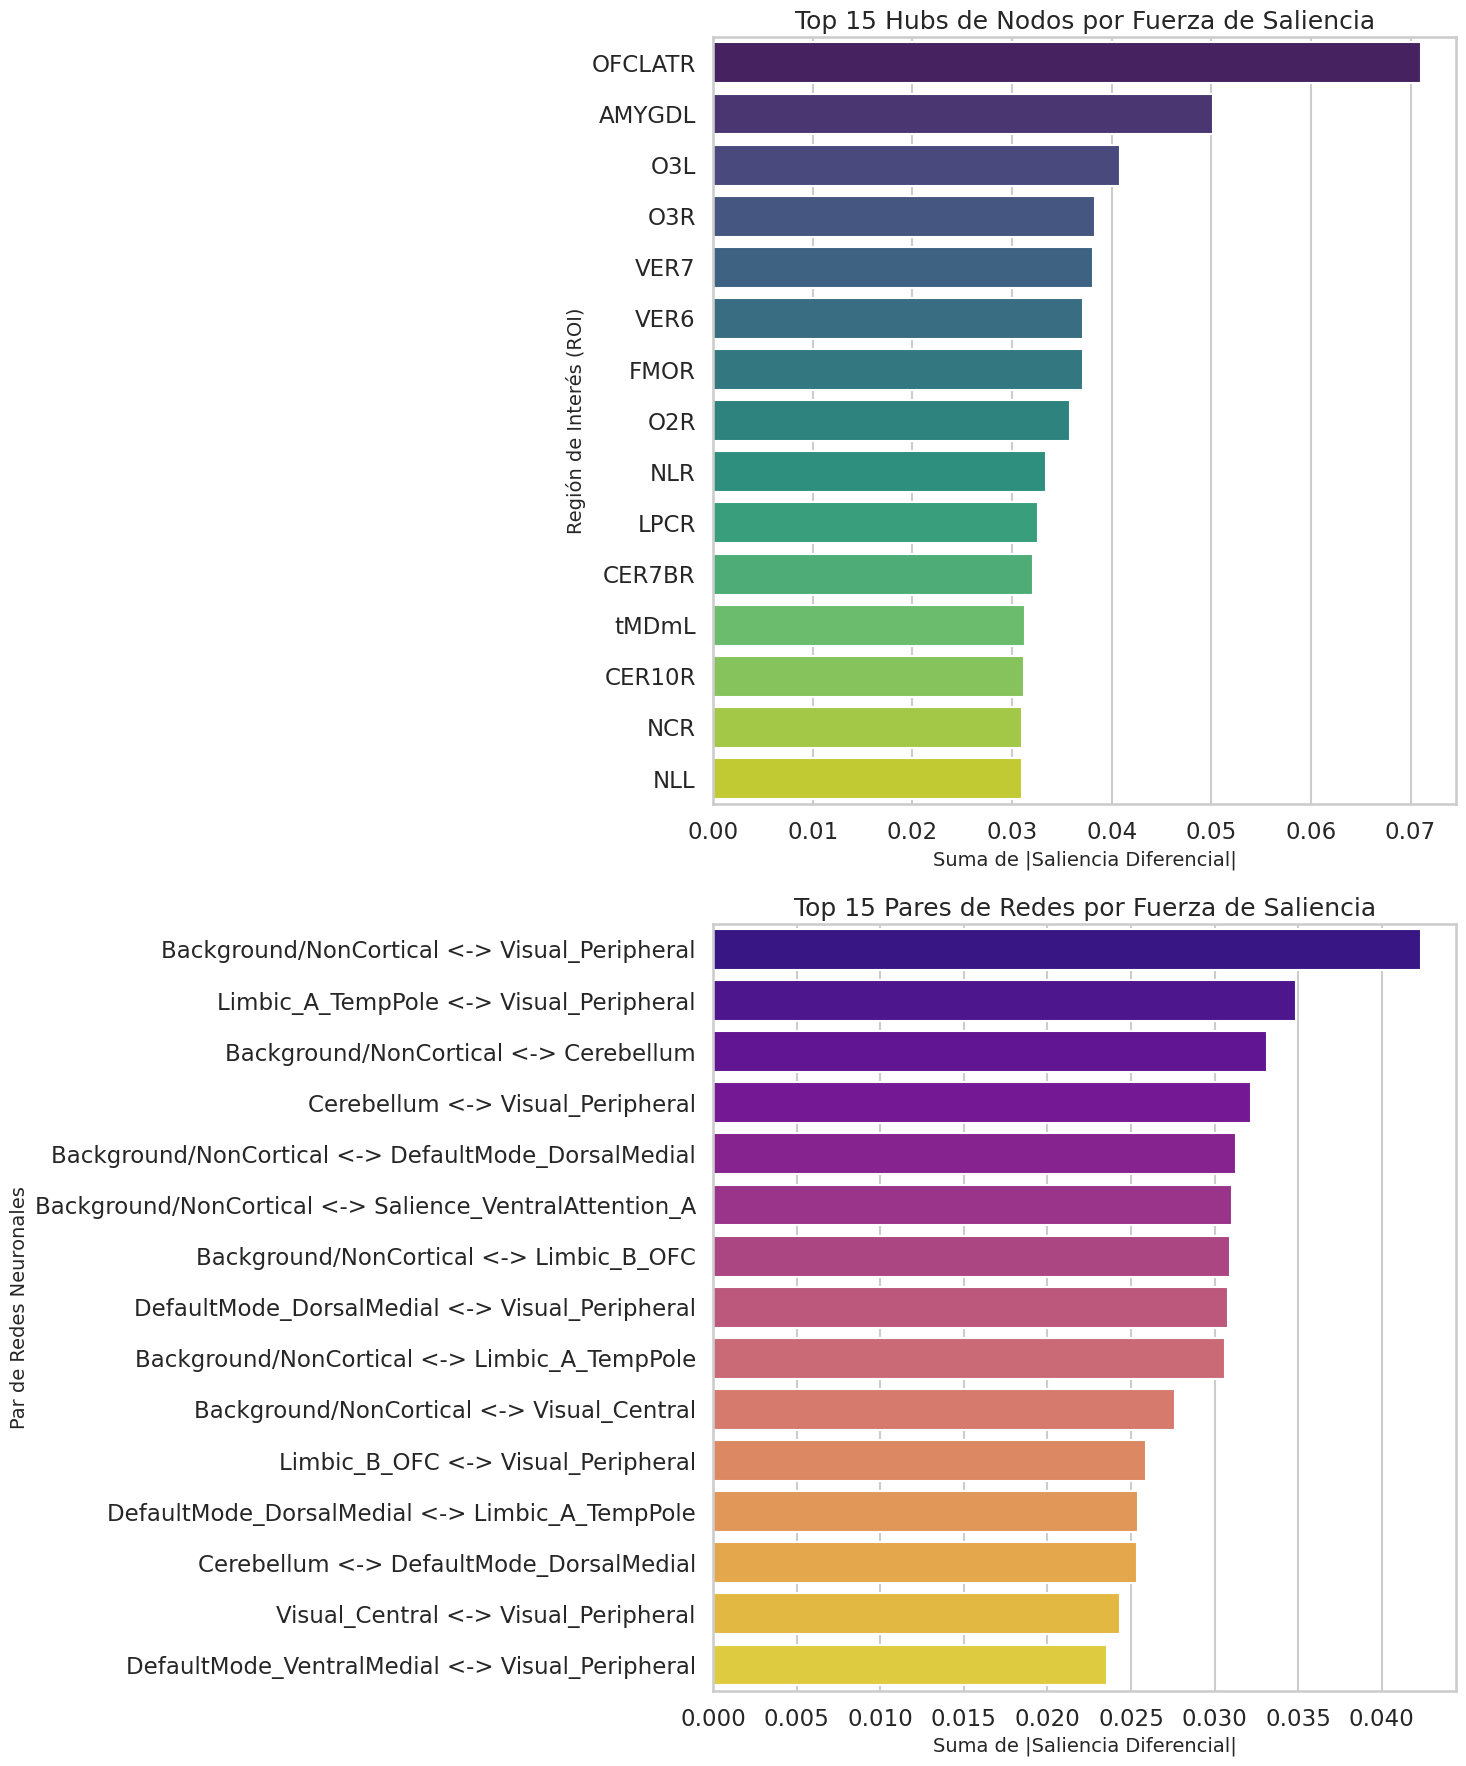


Top 5 Hubs de Nodos:
ROI
OFCLATR    0.071004
AMYGDL     0.050189
O3L        0.040823
O3R        0.038296
VER7       0.038160
Name: Saliency_Score, dtype: float64

Top 5 Pares de Redes:
network_pair
(Background/NonCortical, Visual_Peripheral)           0.042331
(Limbic_A_TempPole, Visual_Peripheral)                0.034894
(Background/NonCortical, Cerebellum)                  0.033134
(Cerebellum, Visual_Peripheral)                       0.032153
(Background/NonCortical, DefaultMode_DorsalMedial)    0.031301
Name: Saliency_Score, dtype: float64


In [14]:
if not df_edges.empty:
    # --- 1. Identificación de Hubs de Nodos ---
    # Para cada conexión (fila), tenemos dos nodos. Usamos melt para tener una lista larga de nodos y su saliencia.
    df_nodes_i = df_edges[['src_AAL3_Name', 'Saliency_Score']].rename(columns={'src_AAL3_Name': 'ROI'})
    df_nodes_j = df_edges[['dst_AAL3_Name', 'Saliency_Score']].rename(columns={'dst_AAL3_Name': 'ROI'})
    
    df_nodes_long = pd.concat([df_nodes_i, df_nodes_j], ignore_index=True)
    
    # Agrupamos por ROI y sumamos la magnitud de la saliencia
    node_saliency_strength = df_nodes_long.groupby('ROI')['Saliency_Score'].apply(lambda x: np.abs(x).sum()).sort_values(ascending=False)
    
    # --- 2. Identificación de Pares de Redes ---
    # Creamos una clave única para cada par de redes para evitar duplicados (p.ej., DMN-Limbic es igual a Limbic-DMN)
    df_edges['network_pair'] = df_edges.apply(
        lambda row: tuple(sorted((row['src_Refined_Network'], row['dst_Refined_Network']))),
        axis=1
    )
    
    network_pair_strength = df_edges.groupby('network_pair')['Saliency_Score'].apply(lambda x: np.abs(x).sum()).sort_values(ascending=False)

    # --- Visualización ---
    fig, axes = plt.subplots(2, 1, figsize=(15, 18))
    
    # Plot de Hubs
    top_n_nodes = 15
    sns.barplot(x=node_saliency_strength.head(top_n_nodes).values, y=node_saliency_strength.head(top_n_nodes).index, ax=axes[0], palette="viridis")
    axes[0].set_title(f'Top {top_n_nodes} Hubs de Nodos por Fuerza de Saliencia')
    axes[0].set_xlabel('Suma de |Saliencia Diferencial|')
    axes[0].set_ylabel('Región de Interés (ROI)')
    
    # Plot de Pares de Redes
    top_n_pairs = 15
    # Formatear las etiquetas para que sean legibles
    pair_labels = [" <-> ".join(map(str, pair)) for pair in network_pair_strength.head(top_n_pairs).index]
    sns.barplot(x=network_pair_strength.head(top_n_pairs).values, y=pair_labels, ax=axes[1], palette="plasma")
    axes[1].set_title(f'Top {top_n_pairs} Pares de Redes por Fuerza de Saliencia')
    axes[1].set_xlabel('Suma de |Saliencia Diferencial|')
    axes[1].set_ylabel('Par de Redes Neuronales')

    plt.tight_layout()
    plt.show()

    print("\nTop 5 Hubs de Nodos:")
    print(node_saliency_strength.head())
    print("\nTop 5 Pares de Redes:")
    print(network_pair_strength.head())

## Saliencia vs. Efecto de Conectividad: ¿Qué Mide Cada Cosa?

Una pregunta fundamental es si la saliencia del modelo simplemente refleja grandes diferencias en la conectividad media entre grupos, o si captura patrones más sutiles (p.ej., diferencias en varianza o interacciones no lineales).

Para investigarlo, calcularemos el **tamaño del efecto de grupo (d de Cohen)** para cada conexión y lo correlacionaremos con la **magnitud de la saliencia**.

-   **d de Cohen:** Mide la diferencia estandarizada de medias entre los grupos AD y CN para la conectividad de un enlace específico. Un |d| alto significa una gran diferencia en la conectividad media.
-   **Magnitud de Saliencia:** Mide cuán *importante* es esa conexión para el modelo, independientemente del valor de conectividad.

Una correlación alta sugeriría que el modelo se fija principalmente en diferencias de medias. Una correlación baja sugeriría que el modelo está usando información más compleja para discriminar.